In [1]:
import numpy as np
from scipy.sparse import eye, csr_matrix
from scipy.linalg import inv, khatri_rao

def cov_matern(d, loghyper, x):
    ell = np.exp(loghyper[0])
    sf2 = np.exp(2 * loghyper[1])    
    def f(t):
        if d == 1: return 1
        if d == 3: return 1 + t
        if d == 5: return 1 + t * (1 + t / 3)
        if d == 7: return 1 + t * (1 + t * (6 + t) / 15)       
    def m(t):
        return f(t) * np.exp(-t)   
    dist_sq = ((x[:, None] - x[None, :]) / ell) ** 2
    return sf2 * m(np.sqrt(d * dist_sq))

def bohman(loghyper, x):
    range_ = np.exp(loghyper[0])
    dis = np.abs(x[:, None] - x[None, :])
    r = np.minimum(dis / range_, 1)
    k = (1 - r) * np.cos(np.pi * r) + np.sin(np.pi * r) / np.pi
    k[k < 1e-16] = 0
    k[np.isnan(k)] = 0
    return k

def unfold(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

def fold(mat, dim, mode):
    index = list()
    index.append(mode)
    for i in range(dim.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(dim[index]), order = 'F'), 0, mode)

def Ap_operatorT(vec, maskT, KrU, KrU_T, Qu, rho, R, M):
    X = vec.reshape(R, M, order = 'F')        
    temp = maskT * (KrU @ X)       
    Ap1 = KrU_T @ temp   
    Ap2 = rho * (X @ Qu)
    return (Ap1 + Ap2).ravel(order = 'F')

def cg_factorT(Qu, rho, KrU, mask_matrixT, YR_tilde, priorvalue, max_iter):
    R, M = YR_tilde.shape   
    Y_flat = YR_tilde.ravel(order = 'F')    
    x = priorvalue.copy()
    KrU_T = KrU.T   
    Ax = Ap_operatorT(x, mask_matrixT, KrU, KrU_T, Qu, rho, R, M)
    r = Y_flat - Ax
    p = r.copy()
    rsold = np.dot(r, r)
    approxE = np.zeros(max_iter)    
    for i in range(max_iter):
        Ap = Ap_operatorT(p, mask_matrixT, KrU, KrU_T, Qu, rho, R, M)
        alpha = rsold / np.dot(p, Ap)
        x += alpha * p
        r -= alpha * Ap
        rsnew = np.dot(r, r)
        approxE[i] = np.sqrt(rsnew)
        if approxE[i] < 1e-6:
            break
        p = r + (rsnew / rsold) * p
        rsold = rsnew       
    return x, approxE

def kroneckerMVM(K3, K2, K1, vec, d1, d2, d3):
    temp1 = (K1 @ vec.reshape(d1, d2, d3, order = 'F').reshape(d1, -1)).reshape(d1, d2, d3)
    temp2 = (K2 @ temp1.transpose(1, 0, 2).reshape(d2, -1)).reshape(d2, d1, d3).transpose(1, 0, 2)
    temp3 = (K3 @ temp2.transpose(2, 0, 1).reshape(d3, -1)).reshape(d3, d1, d2).transpose(1, 2, 0)
    return temp3.ravel(order = 'F')

def Ap_operatorL(vec, pos_obs, Kd, Kt, Ks, gamma, d1, d2, d3):
    x = np.zeros(d1 * d2 * d3)
    x[pos_obs] = vec
    Ap1 = kroneckerMVM(Kd, Kt, Ks, x, d1, d2, d3)
    return Ap1[pos_obs] + gamma * vec

def cg_local(gamma, Kd, Kt, Ks, pos_obs, YR_tilde, priorvalue, max_iter):
    d1, d2, d3  = YR_tilde.shape
    Y_obs = (YR_tilde.ravel(order = 'F'))[pos_obs]
    x = priorvalue.copy()
    Ax = Ap_operatorL(x, pos_obs, Kd, Kt, Ks, gamma, d1, d2, d3)
    r = Y_obs - Ax
    p = r.copy()
    rsold = np.dot(r, r)
    approxE = np.zeros(max_iter)
    for i in range(max_iter):
        Ap = Ap_operatorL(p, pos_obs, Kd, Kt, Ks, gamma, d1, d2, d3)
        alpha = rsold / np.dot(p, Ap)
        x += alpha * p
        r -= alpha * Ap
        rsnew = np.dot(r, r)
        approxE[i] = np.sqrt(rsnew)
        if approxE[i] < 1e-6:
            break       
        p = r + (rsnew / rsold) * p
        rsold = rsnew
    return x, approxE

In [2]:
def GLSKF(I, Omega, lengthscaleU: list, lengthscaleR: list, varianceU: list, varianceR: list, tapering_range, d_MaternU, d_MaternR, R, rho, gamma, maxiter, K0, epsilon):
    N = np.array(I.shape)
    D = I.ndim
    maxP = float(np.max(I))

    Omega = Omega.astype(bool)
    pos_miss = np.where(Omega == 0)
    num_obser = np.sum(Omega)
    mask_matrix = [unfold(Omega, d) for d in range(D)]
    idx = np.sum(mask_matrix[2], axis = 0) > 0
    train_matrix = I * Omega
    train_matrix = train_matrix[train_matrix > 0]
    Isubmean = I - np.mean(train_matrix)
    T = Isubmean * Omega
    mask_matrixT = [mask_matrix[d].T for d in range(D)]
    mask_flat = [mask_matrix[d].ravel(order = 'F') for d in range(D)]
    pos_obs = [np.where(mask_flat[d] == 1) for d in range(D)]

    hyper_Ku = [None] * D
    hyper_Ku[0] = [np.log(lengthscaleU[0]), np.log(varianceU[0])]
    hyper_Ku[1] = [np.log(lengthscaleU[1]), np.log(varianceU[1])]   
    hyper_Kr = [None] * D
    hyper_Kr[0] = [np.log(lengthscaleR[0]), np.log(varianceR[0]), np.log(tapering_range)]
    hyper_Kr[1] = [np.log(lengthscaleR[1]), np.log(varianceR[1]), np.log(tapering_range)]

    Ku, Kr = [None] * D, [None] * D
    invKu = [None] * D

    x = np.arange(1, N[0] + 1)
    Ku[0] = cov_matern(d_MaternU, hyper_Ku[0], x)
    invKu[0] = inv(Ku[0])
    TaperM = bohman([hyper_Kr[0][2]], x)
    Kr[0] = csr_matrix(cov_matern(d_MaternR, hyper_Kr[0][:2], x) * TaperM)

    x = np.arange(1, N[1] + 1)
    Ku[1] = cov_matern(d_MaternU, hyper_Ku[1], x)
    invKu[1] = inv(Ku[1])
    TaperM = bohman([hyper_Kr[1][2]], x)
    Kr[1] = csr_matrix(cov_matern(d_MaternR, hyper_Kr[1][:2], x) * TaperM)

    invKu[2] = csr_matrix(eye(N[2]))
    Kr[2] = csr_matrix(eye(N[2]))

    X = T
    X[pos_miss] = T.sum() / num_obser
    U = [0.1 * np.random.randn(N[d], R) for d in range(D)]
    M_unfold1 = U[0] @ khatri_rao(U[2], U[1]).T
    M = fold(M_unfold1, N, 0)
    Uvector = [U[d].ravel(order = 'F') for d in range(D)]
    UTvector = [U[d].T.ravel(order = 'F') for d in range(D)]
    Rtensor = np.zeros(N)
    Rvector = Rtensor.ravel(order = 'F')   
    Rvector_temp = Rtensor.ravel(order = 'F')
    X[pos_miss] = M[pos_miss] + Rtensor[pos_miss]

    d_all = np.arange(0, D)
    train_norm = np.linalg.norm(T)
    last_ten = T.copy()
    psnrf = np.zeros(maxiter)
    approxU = [None] * D
    iter = 0
    while True:
        Gtensor = X - Rtensor
        Gtensor_mask = Gtensor * Omega
        for d in range(D):
            dsub = np.delete(d_all, d)
            KrU = khatri_rao(U[dsub[1]], U[dsub[0]])          
            HG = KrU.T @ unfold(Gtensor_mask, d).T
            UTvector[d], approxU[d] = cg_factorT(invKu[d], rho, KrU, mask_matrixT[d], HG, UTvector[d], 1000)           
            U[d] = (UTvector[d].reshape(R, N[d], order = 'F')).T          
        M_unfold1 = U[0] @ (khatri_rao(U[2], U[1]).T)
        M = fold(M_unfold1, N, 0)
        X[pos_miss] = M[pos_miss] + Rtensor[pos_miss]
        if iter >= K0:
            Ltensor = X - M
            Ltensor_mask = Ltensor * Omega
            Rvector_temp[pos_obs[0]], approxE = cg_local(gamma, Kr[2], Kr[1], Kr[0], pos_obs[0], Ltensor_mask, Rvector_temp[pos_obs[0]], 1000)
            Rvector = kroneckerMVM(Kr[2], Kr[1], Kr[0], Rvector_temp, N[0], N[1], N[2])
            Rtensor = Rvector.reshape(N, order = 'F')
            Rtensor_unfold3 = unfold(Rtensor, 2)
            Rtensor_unfold3_obs = Rtensor_unfold3[:, idx]
            Kr[2] = np.cov(Rtensor_unfold3_obs)          
        else:
            Rtensor = np.zeros_like(Rtensor)    
        X[pos_miss] = M[pos_miss] + Rtensor[pos_miss]
        Xori = X + np.mean(train_matrix)
        Xrecovery = np.maximum(0, Xori)
        Xrecovery = np.minimum(maxP, Xrecovery)
        mseC1 = np.linalg.norm(I[:, :, 0].astype(float) - Xrecovery[:, :, 0], 'fro') ** 2 / (N[0] * N[1])
        psnrC1 = 10 * np.log10(maxP**2 / mseC1)
        mseC2 = np.linalg.norm(I[:, :, 1].astype(float) - Xrecovery[:, :, 1], 'fro') ** 2 / (N[0] * N[1])
        psnrC2 = 10 * np.log10(maxP**2 / mseC2)
        mseC3 = np.linalg.norm(I[:, :, 2].astype(float) - Xrecovery[:, :, 2], 'fro') ** 2 / (N[0] * N[1])
        psnrC3 = 10 * np.log10(maxP**2 / mseC3)
        psnrf[iter] = (psnrC1 + psnrC2 + psnrC3)/3
        iter += 1
        print(f"Epoch = {iter}, PSNR = {psnrf[iter-1]}")
        tol = np.linalg.norm((X - last_ten)) / train_norm
        last_ten = X.copy()       
        if (tol < epsilon) or (iter >= maxiter):
            break
    return Xori, Rtensor + np.mean(train_matrix), M + np.mean(train_matrix)

In [3]:
from PIL import Image
import scipy.io
seedr = 7
np.random.seed(seedr)
I = np.array(Image.open('./data/original/airplane.tiff'))
Omega = scipy.io.loadmat('./data/mask/airplane_90RM.mat')['Omega']
lengthscaleU = np.ones(2) * 30
varianceU = np.ones(2)
lengthscaleR = np.ones(2) * 5
varianceR = np.ones(2)
tapering_range = 30
d_MaternU, d_MaternR = 3, 3
R = 10
rho, gamma = 20, 5
maxiter, K0 = 30, 10
epsilon = 1e-4
X, Rtensor, Mtensor = GLSKF(I, Omega, lengthscaleU, lengthscaleR, varianceU, varianceR, tapering_range, d_MaternU, d_MaternR, R, rho, gamma, maxiter, K0, epsilon)

Epoch = 1, PSNR = 17.279169040203374
Epoch = 2, PSNR = 20.17462904303201
Epoch = 3, PSNR = 20.50419982139328
Epoch = 4, PSNR = 20.609871838460524
Epoch = 5, PSNR = 20.69211736947996
Epoch = 6, PSNR = 20.781809594666438
Epoch = 7, PSNR = 20.87115837930631
Epoch = 8, PSNR = 20.921025147305155
Epoch = 9, PSNR = 20.94879292333574
Epoch = 10, PSNR = 20.967216255381803
Epoch = 11, PSNR = 23.23586534207928
Epoch = 12, PSNR = 27.013108452966776
Epoch = 13, PSNR = 27.361382151538418
Epoch = 14, PSNR = 27.377163325139804
Epoch = 15, PSNR = 27.38080744217326
Epoch = 16, PSNR = 27.382859629011673
Epoch = 17, PSNR = 27.384614409752164
Epoch = 18, PSNR = 27.3862104645517
Epoch = 19, PSNR = 27.387636527773623
Epoch = 20, PSNR = 27.388883806220367
Epoch = 21, PSNR = 27.389955909590082
Epoch = 22, PSNR = 27.390863238058426
Epoch = 23, PSNR = 27.391625439690355
Epoch = 24, PSNR = 27.39225557624668
Epoch = 25, PSNR = 27.39276675468029
Epoch = 26, PSNR = 27.393172201292995
Epoch = 27, PSNR = 27.3934857947

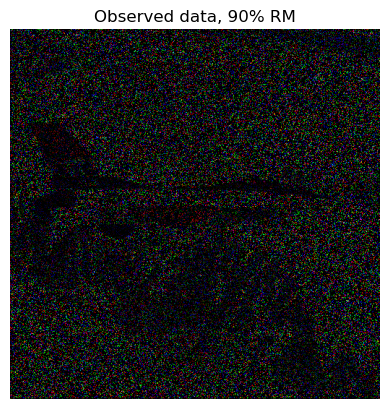

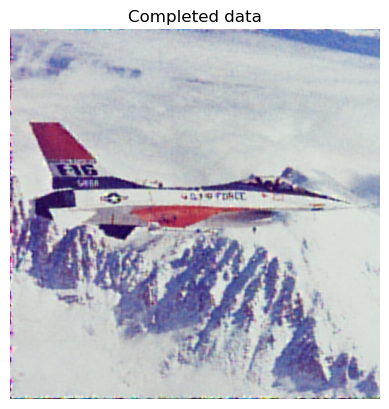

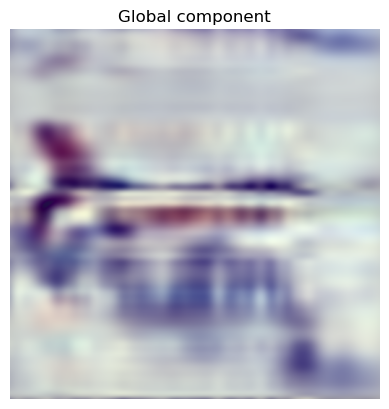

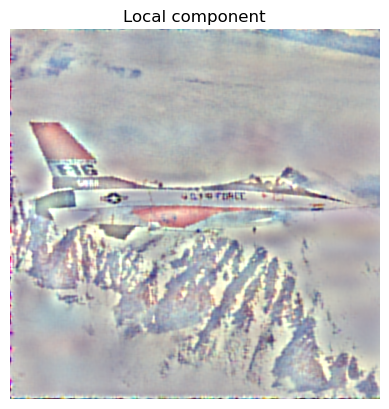

In [4]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(np.uint8(np.minimum(255, np.abs(I * Omega))))
plt.title('Observed data, 90% RM')
plt.axis("off")
plt.figure()
plt.imshow(np.uint8(np.minimum(255, np.abs(X))))
plt.title('Completed data')
plt.axis("off")
plt.figure()
plt.imshow(np.uint8(np.minimum(255, np.abs(Mtensor))))
plt.title('Global component')
plt.axis("off")
plt.figure()
plt.imshow(np.uint8(np.minimum(255, np.abs(Rtensor))))
plt.title('Local component')
plt.axis("off")
plt.show()